# Final Project: Redistricing Project of Oklahoma and Oregon. 
### Class: IE 5318 Principles of Operations Reasearch
### Team Members: Natalie Ventura, Jessica Dedeaux, Damilola Fasheru
### Date: Fall 2023; 12-12-2023

In [1]:
# GitHub Project file: https://github.com/Jdedeaux/Districts-Counties/tree/main
# Credit to: 
#     Dr. Hamidreza Validi transportation, short path codes, and assigment codes: IE 5318 Principles of Operations Reasearch at Texas Tech University
#     Dr. Austin Buchanan districting example starter code: https://github.com/AustinLBuchanan/Districting-Examples/tree/main
#     Gurobi Optimization Tutorial via the primary website: https://www.gurobi.com/resources/lp-chapter-6-modeling-and-solving-linear-programming-problems/
#     Dr. Gabrielle Taylor: https://github.com/gabrielletay96
#     shapefiles: https://www.youtube.com/watch?v=xxg4Vm-Xg9g
#     for loops: https://www.youtube.com/watch?v=KWgYha0clzw&t=172s
#     Data: http://people.csail.mit.edu/ddeford/dual_graphs
#     Data: https://lykhovyd.com/files/public/districting/2020/
#     nested for loops: https://www.youtube.com/watch?v=APWy6Pc83gE
#     Networknx Package: https://networkx.org/documentation/stable/auto_examples/drawing/plot_labels_and_colors.html

## OKLAHOMA: Code Verification

In [2]:
# Import the following packages to run various cells
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import geopandas as gpd
import math
from gerrychain import Graph
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Define the edges and nodes of the model

<class 'networkx.classes.graph.Graph'>
The Oklahoma graph has 77 nodes
The Oklahoma graph has 195 edges
Oklahoma graph has nodes [0, 23, 30, 47, 76, 1, 5, 8, 33, 46, 61, 2, 10, 13, 15, 37, 42, 57, 66, 3, 25, 44, 74, 4, 17, 29, 49, 55, 9, 16, 6, 7, 22, 41, 54, 67, 40, 11, 53, 56, 45, 59, 62, 70, 48, 12, 21, 24, 28, 32, 51, 38, 52, 14, 18, 58, 71, 19, 34, 68, 20, 26, 39, 27, 35, 64, 69, 63, 31, 43, 75, 36, 60, 72, 65, 50, 73]
Oklahoma graph has edges [(0, 23), (0, 30), (0, 47), (0, 76), (23, 1), (23, 5), (23, 22), (23, 33), (23, 47), (23, 76), (30, 21), (30, 38), (30, 47), (30, 51), (30, 52), (30, 76), (47, 16), (47, 21), (76, 20), (76, 22), (76, 52), (1, 5), (1, 8), (1, 33), (1, 46), (1, 61), (5, 9), (5, 16), (5, 61), (8, 11), (8, 33), (8, 46), (8, 53), (8, 56), (33, 6), (33, 11), (33, 22), (33, 54), (46, 3), (46, 53), (46, 61), (46, 74), (61, 3), (61, 9), (61, 25), (61, 62), (2, 10), (2, 13), (2, 15), (2, 37), (2, 42), (2, 57), (2, 66), (10, 15), (10, 48), (10, 66), (13, 37), (13, 38),

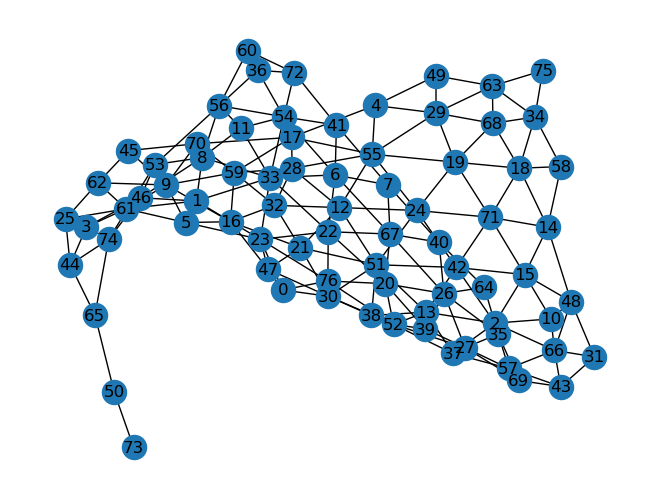

In [3]:
# Create the intial node and edges model using the edges list for Oklahoma
# Remove the non-integers from the text file and ensure it is a plain text file.
filepath = '/Users/jessi/Gurobi-Python Playground/OK.graph'

# reading from the data set
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# drawing the graph
nx.draw(G, with_labels=True)

# Current model description
print("The Oklahoma graph has",G.number_of_nodes(),"nodes")
print("The Oklahoma graph has",G.number_of_edges(),"edges")
print("Oklahoma graph has nodes",G.nodes )
print("Oklahoma graph has edges",G.edges )

### Step 2: List the county populations

In [4]:
# Integrate the populations by county to the model

# create population list
population = list()

# read text file into software system using files on local drive
filepath = "/Users/jessi/Gurobi-Python Playground/OK-2.population"
file = open( filepath,"r")

# Create List for each county population
Listpop = []
for each in file:
    #split the list so the populations in each range
    each = each.split(' ')
    #print((each[1])
    Listpop.append(int(each[1]))
    
# displays the list of integers  
print("Oklahoma's county populations = ", Listpop)

# the sums can be taken by list position
total_population = sum(Listpop)

#print the total population of OK
print("The total_population of Oklahoma = ", total_population)
population = Listpop #label for code clarity
n =len(population)

#print the county population as a sum districts of OK
print("Oklahoma's number of counties = ",n)
print("Population data is", type(population))

Oklahoma's county populations =  [255755, 11943, 45837, 20081, 50976, 15034, 124098, 6193, 27469, 60580, 11154, 11629, 69967, 14003, 42391, 12769, 41848, 47472, 46987, 73085, 27576, 34273, 52431, 115541, 40069, 8878, 47557, 10957, 16577, 86905, 69442, 33151, 77350, 29600, 41487, 15840, 6239, 5925, 25482, 13488, 6472, 7992, 20252, 15205, 3685, 4527, 4810, 718633, 50384, 10536, 20640, 12191, 37492, 3647, 9446, 603403, 22119, 14182, 22683, 11561, 2922, 7527, 5642, 15029, 9423, 5636, 11572, 45048, 41259, 42416, 46562, 70990, 26446, 2475, 4151, 31848, 34506]
The total_population of Oklahoma =  3751351
Oklahoma's number of counties =  77
Population data is <class 'list'>


### Step 3: Population Deviation Model

In [5]:
# If model is feasible, use the population deviation operations research model.
# create model 
m = gp.Model()
#number of districts per the 2020 census for OK
k = 5 

# create variables adapted from districting starter models
x = m.addVars(n,k, vtype=GRB.BINARY) # x_ij equals one when county i is assigned to district j
y = m.addVar()                      # the population of least-populated district
z = m.addVar()                      # the population of most-populated district

# objective is to minimize absolute population deviation
m.setObjective(z-y, GRB.MINIMIZE)

# add constraints saying that each county i is assigned to one district
m.addConstrs( sum(x[i,j] for j in range(k)) == 1 for i in range(n) )

# add constraints saying that each district has population at least y
m.addConstrs(y <= sum(population[i] * x[i,j] for i in range(n)) for j in range(k) )

# add constraints saying that each district has population at most z
m.addConstrs( sum( population[i] * x[i,j] for i in range(n)) <= z for j in range(k) )

# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 87 rows, 387 columns and 1165 nonzeros
Model fingerprint: 0x235259e8
Variable types: 2 continuous, 385 integer (385 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1149841.0000
Presolve time: 0.00s
Presolved: 87 rows, 387 columns, 1165 nonzeros
Variable types: 0 continuous, 387 integer (385 binary)

Root relaxation: objective 0.000000e+00, 125 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    7 1149841.00    0.00000   100%     -    0s
H    0     0                    339690.00000  

### Step 4: Current model status for population

In [6]:
# print the absolute population deviation
print("The absolute population deviation is",m.objval,"person(s).")
print("Oklahoma has districts =",k)

The absolute population deviation is 1.0 person(s).
Oklahoma has districts = 5


### Step 5: create model to access the minimization of cut edges using the county to district populations

In [7]:
filepath = '/Users/jessi/Gurobi-Python Playground/OK_county.json'
G = Graph.from_json(filepath)
print(G.nodes)

m = gp.Model()
#check the list of nodes and matches are align with the mapping data
print(G.nodes)
print(G.edges)

for node in G.nodes:
    # using the columns, located the population
    population = G.nodes[node]['TOTPOP']
    
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)
print(total_population)

# Impose a 3% population deviation (+/- 0.5%) for the Operations Research model
deviation = 0.03
#number of counties
n 
# number of districts
k 

# Lower and Upper bound populations to ensure the populations of the districts do not exceed the bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

# create variables adapted from redistricitng starter: 
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

# solve IP model
m.optimize()

# print the optimal minization of cut edges
print("Oklahoma: The number of cut edges is",m.objval)
print("Oklahoma: Using Lower Bound of Population =",L,"and Upper Bound of Population =",U,"and districts =",k)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
[(0, 66), (0, 57), (0, 61), (0, 73), (0, 27), (1, 51), (1, 22), (1, 45), (1, 56), (1, 68), (1, 53), (1, 46), (2, 26), (2, 63), (2, 36), (2, 31), (2, 43), (3, 32), (3, 37), (3, 71), (3, 72), (4, 40), (4, 28), (4, 22), (4, 24), (5, 72), (5, 25), (5, 20), (5, 47), (5, 58), (6, 20), (6, 58), (6, 75), (6, 19), (7, 71), (7, 72), (7, 65), (7, 20), (8, 32), (8, 52), (8, 71), (8, 35), (9, 52), (9, 40), (9, 5

### Step 6: Retrieve the districts and their populations

In [8]:
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district status
for j in range(k):
    print("Oklahoma: District",j,"has population",district_populations[j],"and contains counties",districts[j])

Oklahoma: District 0 has population 761154 and contains counties [0, 1, 4, 9, 12, 13, 14, 21, 22, 24, 27, 28, 29, 30, 33, 38, 40, 42, 46, 48, 50, 53, 54, 56, 57, 61, 62, 66, 68, 70, 73]
Oklahoma: District 1 has population 741748 and contains counties [15, 18, 41]
Oklahoma: District 2 has population 751820 and contains counties [17, 23, 49, 74]
Oklahoma: District 3 has population 740351 and contains counties [2, 5, 6, 10, 11, 16, 19, 25, 26, 31, 34, 36, 37, 39, 43, 47, 55, 58, 59, 60, 63, 64, 69, 76]
Oklahoma: District 4 has population 756278 and contains counties [3, 7, 8, 20, 32, 35, 44, 45, 51, 52, 65, 67, 71, 72, 75]


### Step 7: Node Mapping the counties and districts

<class 'networkx.classes.graph.Graph'>


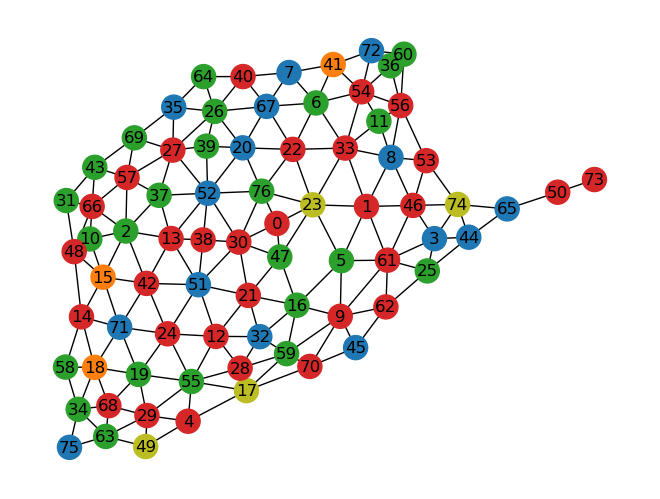

In [9]:
filepath = '/Users/jessi/Gurobi-Python Playground/OK.graph'
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# List of districts
districts = ["District 0","District 1","District 2","District 3","District 4"]

# County to District Dictionary
counties_district_dict = {
"District 0": [0, 1, 4, 9, 12, 13, 14, 21, 22, 24, 27, 28, 29, 30, 33, 38, 40, 42, 46, 48, 50, 53, 54, 56, 57, 61, 62, 66, 68, 70, 73],
"District 1":  [15, 18, 41],
"District 2":  [17, 23, 49, 74],
"District 3":  [2, 5, 6, 10, 11, 16, 19, 25, 26, 31, 34, 36, 37, 39, 43, 47, 55, 58, 59, 60, 63, 64, 69, 76],
"District 4":  [3, 7, 8, 20, 32, 35, 44, 45, 51, 52, 65, 67, 71, 72, 75]
}

# Color dictionary
counties_district_colors_dict = {
    "District 0": "tab:red",
    "District 1": "tab:orange",
    "District 2": "tab:olive",
    "District 3": "tab:green",
    "District 4": "tab:blue"
}

# Defining the position
pos = nx.spring_layout(G)

# Assigning the colors 
color_list = []
for node in G.nodes:   # iteration over nodes
    if node in counties_district_dict['District 0']:
        color_list.append(counties_district_colors_dict['District 0'])

    elif node in counties_district_dict['District 1']:
        color_list.append(counties_district_colors_dict['District 1'])

    elif node in counties_district_dict['District 2']:
        color_list.append(counties_district_colors_dict['District 2'])

    elif node in counties_district_dict['District 3']:
        color_list.append(counties_district_colors_dict['District 3'])
    else: 
        color_list.append(counties_district_colors_dict['District 4'])

nx.draw(G, pos, node_color=color_list,with_labels=True)
plt.show()

### Step 8: State shape Mapping the counties

                                             geometry
0   POLYGON ((-99.36446 35.30577, -99.36446 35.306...
1   POLYGON ((-99.42320 34.72502, -99.42314 34.725...
2   POLYGON ((-98.53366 36.39787, -98.53369 36.404...
3   POLYGON ((-95.00543 36.40142, -95.00543 36.405...
4   POLYGON ((-99.14619 35.81240, -99.14280 35.812...
..                                                ...
72  POLYGON ((-96.62036 35.95931, -96.62051 35.963...
73  POLYGON ((-97.14206 35.14521, -97.14208 35.146...
74  POLYGON ((-99.18527 35.11660, -99.18520 35.116...
75  POLYGON ((-97.24410 33.90427, -97.24505 33.903...
76  POLYGON ((-97.46132 36.43373, -97.46132 36.434...

[77 rows x 1 columns]
<class 'geopandas.geodataframe.GeoDataFrame'>
Oklahoma's counties are in the following districts [[0, 1, 4, 9, 12, 13, 14, 21, 22, 24, 27, 28, 29, 30, 33, 38, 40, 42, 46, 48, 50, 53, 54, 56, 57, 61, 62, 66, 68, 70, 73], [15, 18, 41], [17, 23, 49, 74], [2, 5, 6, 10, 11, 16, 19, 25, 26, 31, 34, 36, 37, 39, 43, 47, 55, 58, 59, 60,

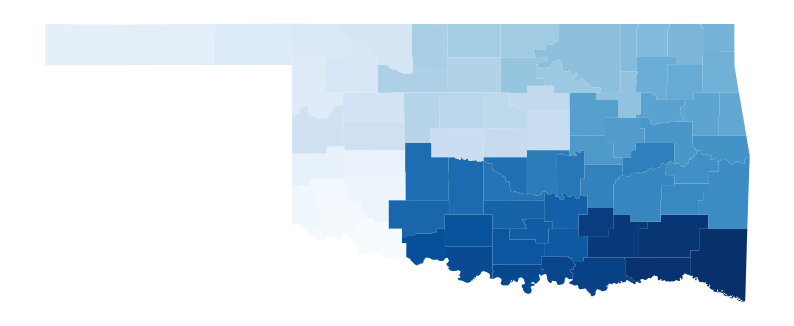

In [10]:
# Read Oklahoma county shapefile and distance files
file1 = '/Users/jessi/Gurobi-Python Playground/OK_distances.csv'
file2 = '/Users/jessi/Gurobi-Python Playground/OK_counties.shx'
file = '/Users/jessi/Gurobi-Python Playground/OK_counties.shp'
#create the data frame
df = gpd.read_file(file)

#checker
print((df))
print(type(df))

#assign the districts to the counties
districts = [[i for i in range(n) if x[i,j].x > 0.5] for j in range(k)]
print("Oklahoma's counties are in the following districts", districts)

# Mapping
fig,ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, column = "geometry", cmap ='Blues')
ax.axis("off")
print("Oklahoma's counties are shown by varied blues in the diagram")

## OREGON

### Step 1: Define the edges and nodes of the model

<class 'networkx.classes.graph.Graph'>
The Oregon graph has 36 nodes
The Oregon graph has 81 edges
Oregon graph has nodes [0, 14, 18, 22, 1, 8, 17, 2, 6, 16, 26, 29, 31, 3, 7, 24, 32, 33, 4, 11, 21, 35, 5, 9, 20, 30, 13, 19, 28, 10, 25, 27, 12, 15, 34, 23]
Oregon graph has edges [(0, 14), (0, 18), (0, 22), (14, 10), (14, 17), (14, 22), (14, 32), (18, 32), (22, 1), (22, 17), (1, 8), (1, 17), (8, 5), (8, 9), (8, 13), (8, 17), (8, 25), (8, 30), (17, 10), (17, 25), (2, 6), (2, 16), (2, 26), (2, 29), (2, 31), (6, 13), (6, 16), (6, 19), (6, 28), (6, 29), (6, 33), (16, 13), (16, 26), (16, 30), (26, 12), (26, 20), (26, 23), (26, 30), (26, 31), (26, 34), (29, 19), (31, 23), (3, 7), (3, 24), (3, 32), (3, 33), (7, 10), (7, 24), (7, 25), (7, 28), (7, 32), (24, 28), (24, 33), (32, 10), (33, 19), (33, 28), (33, 35), (4, 11), (4, 21), (4, 35), (11, 27), (11, 35), (21, 19), (21, 35), (35, 19), (35, 27), (5, 9), (5, 20), (5, 30), (20, 12), (20, 30), (30, 13), (13, 25), (13, 28), (28, 25), (10, 25), (12

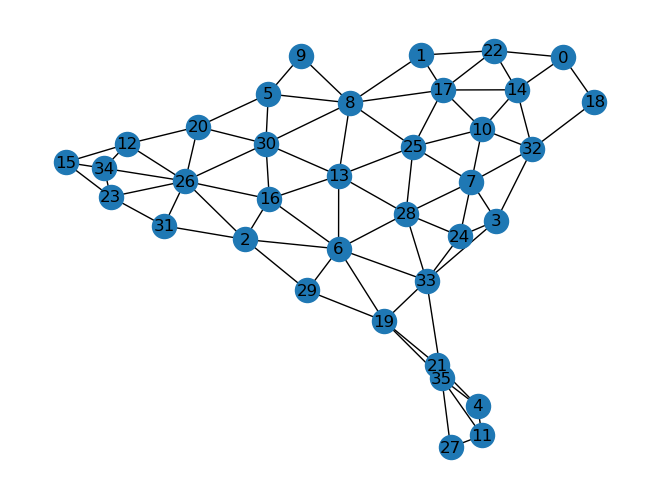

In [11]:
# Create the intial node and edges model using the edges list for Oregon
# Remove the non-integers from the text file and ensure it is a plain text file.
filepath = '/Users/jessi/Gurobi-Python Playground/OR.dimacs-mod.txt'

# reading from the data set
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

# drawing the graph
nx.draw(G, with_labels=True)

# Current model description
print("The Oregon graph has",G.number_of_nodes(),"nodes")
print("The Oregon graph has",G.number_of_edges(),"edges")
print("Oregon graph has nodes",G.nodes )
print("Oregon graph has edges",G.edges )

### Step 2: List the county populations

In [12]:
# Integrate the populations by county to the model

# create population list
population = list()

# read text file into software system using files on local drive
filepath = "/Users/jessi/Gurobi-Python Playground/OR.population"
file = open( filepath,"r")

#remove the header to only read the integers
next(file)

# Create List for each county population
Listpop = []
for each in file:
    #split the list so the populations in each range
    each = each.split(' ')
    #print((each[1])
    Listpop.append(int(each[1]))
    
# displays the list of integers  
print("Oregon's county populations = ", Listpop)

# the sums can be taken by list position
total_population = sum(Listpop)

#print the total population of OR
print("The total_population of Oregon = ", total_population)
population = Listpop #label for code clarity
n =len(population)

#print the county population as a sum districts of OR
print("Oregon's number of counties = ",n)
print("Population data is", type(population))

districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]


Oregon's county populations =  [52589, 23977, 7495, 50395, 88090, 1995, 198253, 87433, 26670, 1870, 107722, 23446, 80075, 24502, 600372, 7391, 24738, 421401, 41072, 69413, 12186, 223259, 815428, 16668, 95184, 345920, 7233, 64929, 128610, 8160, 1451, 31571, 27390, 382971, 26196, 111201]
The total_population of Oregon =  4237256
Oregon's number of counties =  36
Population data is <class 'list'>


### Step 3: Population Deviation Model

In [13]:
# If model is feasible, use the population deviation operations research model.
# create model 
m = gp.Model()
#number of districts per the 2020 census for OR
k = 6 

# create variables adapted from districting starter models
x = m.addVars(n,k, vtype=GRB.BINARY) # x_ij equals one when county i is assigned to district j
y = m.addVar()                      # the population of least-populated district
z = m.addVar()                      # the population of most-populated district

# objective is to minimize absolute population deviation
m.setObjective(z-y, GRB.MINIMIZE)

# add constraints saying that each county i is assigned to one district
m.addConstrs( sum(x[i,j] for j in range(k)) == 1 for i in range(n) )

# add constraints saying that each district has population at least y
m.addConstrs(y <= sum(population[i] * x[i,j] for i in range(n)) for j in range(k) )

# add constraints saying that each district has population at most z
m.addConstrs( sum( population[i] * x[i,j] for i in range(n)) <= z for j in range(k) )

# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 48 rows, 218 columns and 660 nonzeros
Model fingerprint: 0x00001389
Variable types: 2 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 957825.00000
Presolve time: 0.00s
Presolved: 48 rows, 218 columns, 660 nonzeros
Variable types: 0 continuous, 218 integer (216 binary)

Root relaxation: objective 0.000000e+00, 52 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    9 957825.000    0.00000   100%     -    0s
H    0     0                    611097.00000    0

### Step 4: Current model status for population

In [14]:
# print the absolute population deviation
print("The absolute population deviation is",m.objval,"person(s).")
print("Oregon has districts =",k)

# Current district status per the population deviation, since the model is infeasible
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]

# print district status
for j in range(k):
    print("Oregon: District",j,"and contains counties",districts[j])

The absolute population deviation is 131069.0 person(s).
Oregon has districts = 6
Oregon: District 0 and contains counties [0, 16, 7, 32, 33, 20, 30, 19, 34]
Oregon: District 1 and contains counties [22]
Oregon: District 2 and contains counties [14, 26, 3, 9, 13]
Oregon: District 3 and contains counties [17, 31, 11, 35, 12, 23]
Oregon: District 4 and contains counties [8, 2, 29, 24, 28, 25, 27, 15]
Oregon: District 5 and contains counties [18, 1, 6, 4, 21, 5, 10]


### Step 5: Create model to access the minimization of cut edges using the county to district populations

In [ ]:
# data from the county 2010 Census
filepath = '/Users/jessi/Gurobi-Python Playground/OR_county.json'
G = Graph.from_json(filepath)
print(G.nodes)

m = gp.Model()
#check the list of nodes and matches are align with the mapping data
print(G.nodes)
print(G.edges)

for node in G.nodes:
    # using the columns, located the population
    population = G.nodes[node]['TOTPOP']
    
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)
print(total_population)

# Impose a 3% population deviation (+/- 0.5%) for the Operations Research model
deviation = 0.03
#number of counties
n 
# number of districts
k 

# Lower and Upper bound populations to ensure the populations of the districts do not exceed the bounds
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)

# create variables adapted from redistricitng starter: 
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

# solve IP model
m.optimize()

# print the optimal minization of cut edges
print("Oregon: The number of cut edges is",m.objval)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14

In [24]:
# Population Status
print("Oregon: Using Lower Bound of Population =",L,"and Upper Bound of Population =",U,"and districts =",k)
print("Oregon'population deviation is greater than 100; therefore, the model is assumed to be infeasible. This redistricting of OR is a more complex tasking due to counties being larger than others. The model proves the infeasibility.")

Oregon: Using Lower Bound of Population = 628935 and Upper Bound of Population = 648090 and districts = 6
Oregon'population deviation is greater than 100; therefore, the model is assumed to be infeasible. This redistricting of OR is a more complex tasking due to counties being larger than others. The model proves the infeasibility.


### Step 6: Retrieve the districts and their populations

In [25]:
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district status
for j in range(k):
    print("Oregon: District",j,"has population",district_populations[j],"and contains counties",districts[j])

AttributeError: Unable to retrieve attribute 'x'

### Step 7: Node Mapping the counties and districts

<class 'networkx.classes.graph.Graph'>


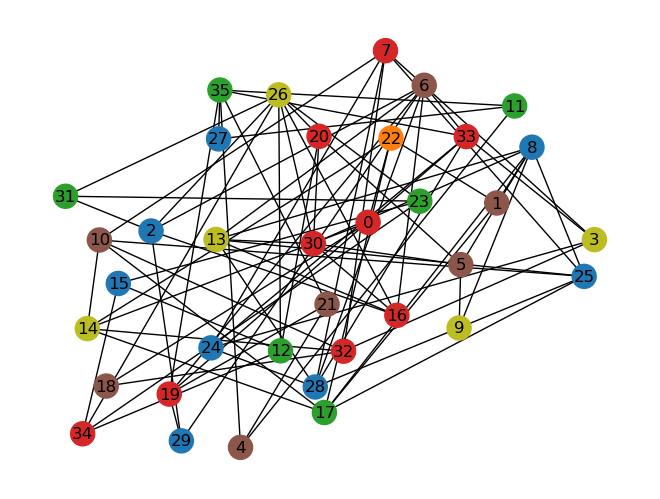

In [16]:
filepath = '/Users/jessi/Gurobi-Python Playground/OR.dimacs-mod.txt'
G = nx.read_edgelist(filepath,nodetype=int)

print(type(G))

districts = ["District 0","District 1","District 2","District 3","District 4","District 5"]

# Assigning a dictionary for the districts
counties_district_dict = {
"District 0": [0, 16, 7, 32, 33, 20, 30, 19, 34],
"District 1":  [22],
"District 2":  [14, 26, 3, 9, 13],
"District 3":  [17, 31, 11, 35, 12, 23],
"District 4":  [8, 2, 29, 24, 28, 25, 27, 15],
"District 5":  [18, 1, 6, 4, 21, 5, 10]
}

# Assigning a color to each district
counties_district_colors_dict = {
    "District 0": "tab:red",
    "District 1": "tab:orange",
    "District 2": "tab:olive",
    "District 3": "tab:green",
    "District 4": "tab:blue",
    "District 5": "tab:brown",

}


# Assigning the colors
color_list = []
for node in G.nodes:   # iteration over nodes
    if node in counties_district_dict['District 0']:
        color_list.append(counties_district_colors_dict['District 0'])

    elif node in counties_district_dict['District 1']:
        color_list.append(counties_district_colors_dict['District 1'])

    elif node in counties_district_dict['District 2']:
        color_list.append(counties_district_colors_dict['District 2'])

    elif node in counties_district_dict['District 3']:
        color_list.append(counties_district_colors_dict['District 3'])
       
    elif node in counties_district_dict['District 4']:
        color_list.append(counties_district_colors_dict['District 4'])
        
    else: 
        color_list.append(counties_district_colors_dict['District 5'])

# Map output
nx.draw(G, pos, node_color=color_list, with_labels=True)
plt.show()

### Step 8: State shape Mapping the counties

                                             geometry
0   POLYGON ((-123.35949 46.01121, -123.35959 46.0...
1   POLYGON ((-121.63812 45.70477, -121.63132 45.7...
2   POLYGON ((-119.89506 43.56813, -119.89506 43.5...
3   POLYGON ((-124.14651 44.77862, -124.14609 44.7...
4   POLYGON ((-124.00393 42.45154, -124.00387 42.4...
5   POLYGON ((-120.36083 45.50569, -120.36080 45.5...
6   POLYGON ((-121.40550 44.39315, -121.40256 44.3...
7   POLYGON ((-123.72466 44.98427, -123.72462 44.9...
8   POLYGON ((-121.71160 45.15282, -121.71222 45.1...
9   POLYGON ((-120.82708 45.51531, -120.82814 45.5...
10  POLYGON ((-123.46310 45.28019, -123.46310 45.2...
11  POLYGON ((-124.54413 42.68382, -124.55310 42.6...
12  POLYGON ((-119.14139 45.93100, -119.13504 45.9...
13  POLYGON ((-121.14964 44.39065, -121.15085 44.3...
14  POLYGON ((-123.20927 45.43371, -123.20976 45.4...
15  POLYGON ((-117.74746 45.83324, -117.74745 45.8...
16  POLYGON ((-121.01452 44.39032, -121.01311 44.3...
17  POLYGON ((-122.74374 45.

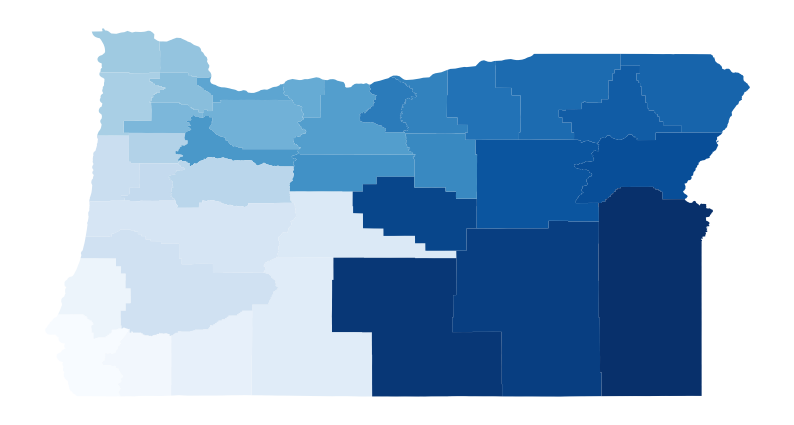

In [17]:
# Read Oregon county shapefile and distance files
file1 = '/Users/jessi/Gurobi-Python Playground/OR_distances.csv'
file2 = '/Users/jessi/Gurobi-Python Playground/OR_counties.shx'
file = '/Users/jessi/Gurobi-Python Playground/OR_counties.shp'
#create the data frame
df = gpd.read_file(file)

#checker
print((df))
print(type(df))


# Mapping
fig,ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, column = "geometry", cmap ='Blues')
ax.axis("off")
print("Oregon's counties are shown by varied blues in the diagram")

In [ ]:
#Trial and Error
# #for loop examples and set-up
# ## x is the place holder that looks in the range
# for x in range(1, 11): 
#     print(x)
# print("Range")

# #for loop counting backwards by two which is the step function
# for x in reversed (range(1, 11, 2)): 
#     print(x)
# print("Backward")

# #printing within a sequence
# ## x holds current position
# Number = "1234-1976-3467"
# for x in Number: 
#     print(x)
# print("Number sequence")

# #skipping a number and looping
# for x in range(1,21):
#     if x == 13:
#         continue
#     else: 
#         print(x)

# #skipping a number and looping
# for x in range(1,21):
#     if x == 13:
#         break
#     else: 
#         print(x)
        
# # Nested for loop examples
# # outer and inner loop, make sure the varible/placeholder/ counters are different

# #call and response
# rows =int(input("Enter the # of rows: "))
# columns =int(input("Enter the # of columns: "))
# symbol = input("Enter a symbol to use: ")
# for x in range(rows): # means 3 iterations, outer loop
# # everytime you print it ends with a new character and proceeds to the next line, 
# # so if we use a string then it will be next to each other
#     for y in range(columns):
#         print (symbol, end =" ")
#     print() #exit inner loop
    
# # number string
# for x in range(3): # means 3 iterations, outer loop
# # everytime you print it ends with a new character and proceeds to the next line, 
# # so if we use a string then it will be next to each other
#     for y in range(1,10):
#         print (y, end ="")
#     print() #exit inner loop

####################
# If using the unmodified .dimacs file, it will need to be manipulated to only utilize integers. Removing column 1, row 1, last row
# filepath = "/Users/jessi/Gurobi-Python Playground/MA.dimacs"
# file = open(filepath)

# #remove the header and tail to over mixing int and str
# next(file)
# last_line = None
# for line in file:
#     if last_line:
#         for line in file:
#             if line.strip():
#                 file.write("\t".join(line.split()[1:]) + "\n")
#         print (last_line)
#         last_line = line
# # for line in file:
# #         try:
# #             r = int(line)
# #             if r > 999 or line.strip() == '-0':
# #                 #filtering numbers >999 and strings with '-0' 
# #                 continue 
# #             file.append(r)
# #         except ValueError:
# #             pass

# # Create List of integers
# # nodes_edges = []
# # for each in file:
# #     each = each.strip()
# #     #split the list so the populations in each range
# #     each = each.split(' ')
# #     print((each[1], each[2]))
# #     nodes_edges.append(int(each[1], each[2]))
#####################

#shifts = range(1,9000000)
# for district in districts:
#     c_counties = counties_district_dict[district]
#     c_color = counties_district_dict[district]